In [1]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2024-05-04 16:15:42.961717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 16:15:42.961746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 16:15:42.962568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 16:15:42.967158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 16:15:43.590152: W tensorflow/compiler/tf2

In [3]:
from sklearn.metrics import classification_report
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import Sequential, Model, Input
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False

seed=123

In [4]:
import mpu
EEG_data_8020 = mpu.io.read('/Users/oak/Downloads/Data_Set/Processed_egg/EEG_data_8020.pickle')
non_split_EEG=mpu.io.read('/Users/oak/Downloads/Data_Set/Processed_egg/non_plit_EEG.pickle')

# Extract the data from the loaded dictionary
X= non_split_EEG['X']
y= non_split_EEG['y']
X_train = EEG_data_8020['X_train']
y_train = EEG_data_8020['y_train']
X_test = EEG_data_8020['X_test']
y_test = EEG_data_8020['y_test']

In [5]:
X_train=X_train.values
X_test=X_test.values

# Reshape input data to have the correct shape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

#Define Parameters
input_dim = X_train.shape[2] 
sequence_length = X_train.shape[1] 
encoding_dim = 8 
batch_size=32
epochs = 50

In [6]:
def create_autoencoder_lstm(input_dim, sequence_length, encoding_dim):
    clear_session()
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, input_dim))
    encoder_lstm1 = LSTM(512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(encoder_inputs)
    encoder_lstm2 = LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(encoder_lstm1)
    encoder_lstm3 = LSTM(16, activation='tanh', recurrent_activation='sigmoid')(encoder_lstm2)
    encoded = Dense(encoding_dim, activation='relu')(encoder_lstm3)
    
    # Decoder
    decoder_inputs = RepeatVector(sequence_length)(encoded)
    decoder_lstm1 = LSTM(16, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(decoder_inputs)
    decoder_lstm2 = LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(decoder_lstm1)
    decoder_lstm3 = LSTM(512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(decoder_lstm2)
    decoded = TimeDistributed(Dense(input_dim, activation='sigmoid'))(decoder_lstm3)
    
    # Autoencoder model
    autoencoder_lstm = Model(inputs=encoder_inputs, outputs=decoded)
    
    # Compile model
    autoencoder_lstm.compile(optimizer='adam', loss='mse')
    
    return autoencoder_lstm

# Assuming input_dim, sequence_length, and encoding_dim are defined earlier
autoencoder_lstm_model = create_autoencoder_lstm(input_dim, sequence_length, encoding_dim)


2024-05-04 16:15:44.285811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 16:15:44.286059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 16:15:44.286227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
autoencoder_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 16)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1083392   
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            328192    
                                                                 
 lstm_2 (LSTM)               (None, 16)                9280      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 8)              0         
 r)                                                              
                                                             

In [8]:
# Train hybrid autoencoder
history=autoencoder_lstm_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=1)

Epoch 1/50


2024-05-04 16:15:49.412519: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-04 16:15:49.788652: I external/local_xla/xla/service/service.cc:168] XLA service 0x75d7700aa590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 16:15:49.788676: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-05-04 16:15:49.792892: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714810549.846473   31794 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28397/28397 [==============================] - 147s 5ms/step - loss: 0.7969 - val_loss: 0.7236
Epoch 2/50
28397/28397 [==============================] - 142s 5ms/step - loss: 0.7819 - val_loss: 0.7186
Epoch 3/50
28397/28397 [==============================] - 143s 5ms/step - loss: 0.7834 - val_loss: 0.7248
Epoch 4/50
28397/28397 [==============================] - 143s 5ms/step - loss: 0.7862 - val_loss: 0.7233
Epoch 5/50
28397/28397 [==============================] - 143s 5ms/step - loss: 0.7740 - val_loss: 0.7076
Epoch 6/50
28397/28397 [==============================] - 143s 5ms/step - loss: 0.7633 - val_loss: 0.6977
Epoch 7/50
28397/28397 [==============================] - 143s 5ms/step - loss: 0.7568 - val_loss: 0.6963
Epoch 8/50
28397/28397 [==============================] - 142s 5ms/step - loss: 0.7567 - val_loss: 0.6964
Epoch 9/50
28397/28397 [==============================] - 142s 5ms/step - loss: 0.7555 - val_loss: 0.6712
Epoch 10/50
28397/28397 [==============================] 

In [9]:
ae_lstm = Model(inputs=autoencoder_lstm_model.input, outputs=autoencoder_lstm_model.layers[2].output)
encoded_train_features = ae_lstm.predict(X_train)

35496/35496 [==============================] - 28s 766us/step


In [10]:
import cuml.svm as svmCU
# Define SVM classifier
svm_classifier = Pipeline([
    ("svm", svmCU.SVC(kernel="rbf", 
                C = 1,
                tol = 1e-3,
                gamma = 'scale'))
])# Train SVM classifier
svm_classifier.fit(encoded_train_features.squeeze(), y_train)

Pipeline(steps=[('svm', SVC())])

In [11]:
# Extract encoded features for the test dataset
encoded_test_features = ae_lstm.predict(X_test)

# Evaluate SVM classifier
y_pred = svm_classifier.predict(encoded_test_features.squeeze())
print(classification_report(y_test, y_pred))

8874/8874 [==============================] - 7s 760us/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79    116985
           1       0.85      0.85      0.85    166983

    accuracy                           0.82    283968
   macro avg       0.82      0.82      0.82    283968
weighted avg       0.82      0.82      0.82    283968



In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, \
    hinge_loss, matthews_corrcoef, PrecisionRecallDisplay, precision_recall_curve
from imblearn.metrics import geometric_mean_score
import seaborn as sns

def evaluate(y_test, y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    loss = hinge_loss(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred, average='macro')
    geometric_mean = geometric_mean_score(y_test, y_pred, average='macro')
    matthews_corr = matthews_corrcoef(y_test, y_pred)
    print('Validation loss:', loss)
    print('Validation accuracy:', accuracy)
    print('F1 score:', f1)
    print('Precision:', precision)
    print('Recall:', recall)
    print('Area Under the Curve:', auc)
    print('Geometric Mean Score:', geometric_mean)
    print('Matthews Correlation Score:', matthews_corr)


def display_plot(y_test, y_pred):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, annot_kws={"fontsize": 15}, fmt='0.0f', cbar=False)

    # Add labels to the plot
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    plt.ylabel('Predicted', fontsize=15)

    plt.show()

Validation loss: 0.5879641368041469
Validation accuracy: 0.8240012959206671
F1 score: 0.8241299971019211
Precision: 0.8242872124100024
Recall: 0.8240012959206671
Area Under the Curve: 0.8191206516368642
Geometric Mean Score: 0.8191206516368642
Matthews Correlation Score: 0.6373085251607288


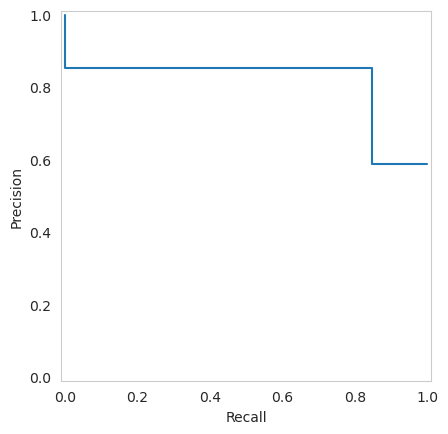

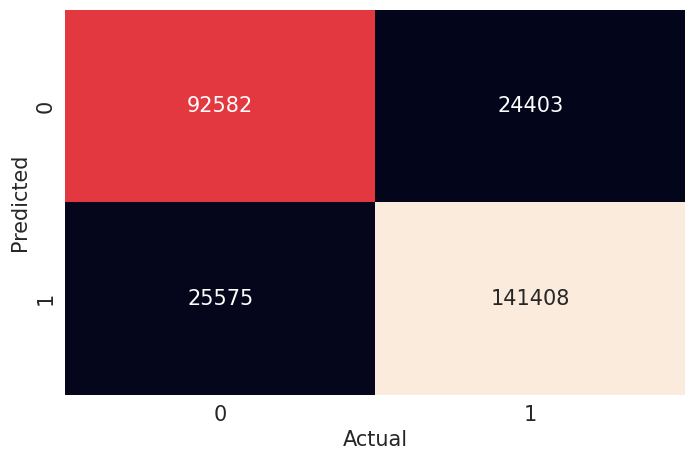

In [13]:
result8020=evaluate(y_test,y_pred)
display_plot(y_test, y_pred)